In [1]:
from __future__ import print_function
import pickle 
import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [2]:
from sub import subMNIST       # testing the subclass of MNIST dataset

Files already downloaded
3000
750


# Split Data

In [3]:
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))
                             ])

In [4]:
trainset_original = datasets.MNIST('../data', train=True, download=True,
                                  transform=transform)

Files already downloaded


In [5]:
#Simon' note
train_label_index = []
valid_label_index = []
for i in range(10):
    train_label_list = trainset_original.train_labels.numpy()
    label_index = np.where(train_label_list == i)[0]
    label_subindex = list(label_index[:300])# Choose 300 images for each labels 3000 in total for training
    valid_subindex = list(label_index[300: 1000 + 300])# validation index have 1000 for each label?
    train_label_index += label_subindex
    valid_label_index += valid_subindex

## Train Set

In [6]:
trainset_np = trainset_original.train_data.numpy()
trainset_label_np = trainset_original.train_labels.numpy()
train_data_sub = torch.from_numpy(trainset_np[train_label_index])
train_labels_sub = torch.from_numpy(trainset_label_np[train_label_index])

In [7]:
trainset_new = subMNIST(root='./data', train=True, download=True, transform=transform, k=3000)
trainset_new.train_data = train_data_sub.clone()
trainset_new.train_labels = train_labels_sub.clone()

Files already downloaded


In [8]:
trainset_new.train_data.size()

torch.Size([3000, 28, 28])

In [9]:
pickle.dump(trainset_new, open("train_labeled.p", "wb" ))

## Validation Set

In [10]:
validset_np = trainset_original.train_data.numpy()
validset_label_np = trainset_original.train_labels.numpy()
valid_data_sub = torch.from_numpy(validset_np[valid_label_index])
valid_labels_sub = torch.from_numpy(validset_label_np[valid_label_index])

In [11]:
validset = subMNIST(root='./data', train=False, download=True, transform=transform, k=10000)
validset.test_data = valid_data_sub.clone()
validset.test_labels = valid_labels_sub.clone()

Files already downloaded


In [12]:
validset.test_data.size()

torch.Size([10000, 28, 28])

In [13]:
pickle.dump(validset, open("validation.p", "wb" ))

## Unlabeled Data

In [14]:
train_unlabel_index = []
for i in range(60000):
    if i in train_label_index or i in valid_label_index:
        pass
    else:
        train_unlabel_index.append(i)

In [15]:
trainset_np = trainset_original.train_data.numpy()
trainset_label_np = trainset_original.train_labels.numpy()
train_data_sub_unl = torch.from_numpy(trainset_np[train_unlabel_index])
train_labels_sub_unl = torch.from_numpy(trainset_label_np[train_unlabel_index])

In [16]:
trainset_new_unl = subMNIST(root='./data', train=True, download=True, transform=transform, k=47000)
trainset_new_unl.train_data = train_data_sub_unl.clone()
trainset_new_unl.train_labels = None      # Unlabeled!!

Files already downloaded


In [17]:
trainset_new_unl.train_data.size()

torch.Size([47000, 28, 28])

In [18]:
trainset_new_unl.train_labels

In [19]:
pickle.dump(trainset_new_unl, open("train_unlabeled.p", "wb" ))

In [20]:
trainset_imoprt = pickle.load(open("train_labeled.p", "rb"))
train_loader = torch.utils.data.DataLoader(trainset_imoprt, batch_size=64, shuffle=True)

In [21]:
train_loader.dataset

# Train Model

In [22]:
# train_loader = torch.utils.data.DataLoader(trainset_new, batch_size=64, shuffle=True)
# valid_loader = torch.utils.data.DataLoader(validset, batch_size=64, shuffle=True)

In [23]:
trainset_imoprt = pickle.load(open("train_labeled.p", "rb"))
validset_import = pickle.load(open("validation.p", "rb"))

In [24]:
train_loader = torch.utils.data.DataLoader(trainset_imoprt, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validset_import, batch_size=64, shuffle=True)

In [25]:
images,labels = iter(train_loader).next()
import matplotlib.pyplot as plt
%matplotlib inline
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

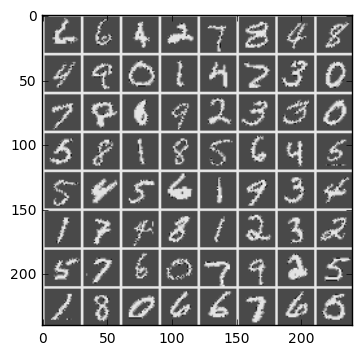

In [26]:
import torchvision
imshow(torchvision.utils.make_grid(images))

In [27]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        return F.log_softmax(x)

model = Net()

In [28]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [29]:
# CPU only training
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def test(epoch, valid_loader):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in valid_loader:

        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss /= len(valid_loader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(valid_loader.dataset),
        100. * correct / len(valid_loader.dataset)))

In [45]:
for epoch in range(1, 200):
    train(epoch)
    test(epoch, valid_loader)

Train Epoch: 1 [0/3000 (0%)]	Loss: 0.639306
Train Epoch: 1 [640/3000 (21%)]	Loss: 0.882284
Train Epoch: 1 [1280/3000 (43%)]	Loss: 0.484027
Train Epoch: 1 [1920/3000 (64%)]	Loss: 0.608564
Train Epoch: 1 [2560/3000 (85%)]	Loss: 0.606069

Test set: Average loss: 0.3314, Accuracy: 9061/10000 (91%)

Train Epoch: 2 [0/3000 (0%)]	Loss: 0.529152
Train Epoch: 2 [640/3000 (21%)]	Loss: 0.567692
Train Epoch: 2 [1280/3000 (43%)]	Loss: 0.584520
Train Epoch: 2 [1920/3000 (64%)]	Loss: 0.588253
Train Epoch: 2 [2560/3000 (85%)]	Loss: 0.536347

Test set: Average loss: 0.3122, Accuracy: 9165/10000 (92%)

Train Epoch: 3 [0/3000 (0%)]	Loss: 0.862157
Train Epoch: 3 [640/3000 (21%)]	Loss: 0.483470
Train Epoch: 3 [1280/3000 (43%)]	Loss: 0.498552
Train Epoch: 3 [1920/3000 (64%)]	Loss: 0.480473
Train Epoch: 3 [2560/3000 (85%)]	Loss: 0.513360

Test set: Average loss: 0.2921, Accuracy: 9189/10000 (92%)

Train Epoch: 4 [0/3000 (0%)]	Loss: 0.463324
Train Epoch: 4 [640/3000 (21%)]	Loss: 0.552998
Train Epoch: 4 [1280/

# Create Sample Submission

In [31]:
testset = datasets.MNIST('../data', train=False, transform=transform)

In [32]:
pickle.dump(testset, open("test.p", "wb" ))

In [33]:
test_loader = torch.utils.data.DataLoader(testset,batch_size=64, shuffle=False)

## Test Accuuracy

In [34]:
test(1, test_loader)


Test set: Average loss: 0.3438, Accuracy: 9053/10000 (91%)



In [35]:
label_predict = np.array([])
model.eval()
for data, target in test_loader:
    data, target = Variable(data, volatile=True), Variable(target)
    output = model(data)
    temp = output.data.max(1)[1].numpy().reshape(-1)
    label_predict = np.concatenate((label_predict, temp))

In [36]:
label_predict

array([ 7.,  2.,  1., ...,  9.,  5.,  6.])

In [37]:
label_true = test_loader.dataset.test_labels.numpy()

In [38]:
diff_array = label_true - label_predict

In [39]:
len(np.where(diff_array != 0)[0])

947

In [40]:
import pandas as pd
true_label = pd.DataFrame(label_true, columns=['label'])
true_label.reset_index(inplace=True)
true_label.rename(columns={'index': 'ID'}, inplace=True)

In [41]:
true_label.head()

,ID,label
0,0,7
1,1,2
2,2,1
3,3,0
4,4,4


In [42]:
predict_label = pd.DataFrame(label_predict, columns=['label'], dtype=int)
predict_label.reset_index(inplace=True)
predict_label.rename(columns={'index': 'ID'}, inplace=True)

In [43]:
predict_label.head()

,ID,label
0,0,7
1,1,2
2,2,1
3,3,0
4,4,4


In [44]:
predict_label.to_csv('sample_submission.csv', index=False)
true_label.to_csv('true_label.csv', index=False)